In [2]:
import librosa
import librosa.display

import cv2
import os

import numpy as np
import matplotlib.pyplot as plt
cv2.__version__

'4.5.5'

In [3]:
librosa.__version__

'0.9.1'

In [4]:
# !ffmpeg -i Tea_witch_SFA(Audio).mp3 Tears_of_a_witch_SFA.wav

In [5]:
'''
테스트 배열 생성
y, sr = librosa.load('Tears_of_a_witch_SFA.wav',sr=None, offset=0, duration=10)
print(y.shape, sr)
np.savez('test.npz',sig=y)
'''

"\n테스트 배열 생성\ny, sr = librosa.load('Tears_of_a_witch_SFA.wav',sr=None, offset=0, duration=10)\nprint(y.shape, sr)\nnp.savez('test.npz',sig=y)\n"

In [6]:
y = np.load('test.npz')['sig']

sr = 44100
print(y.shape)

(441000,)


In [7]:
onset_env = librosa.onset.onset_strength(y=y, sr=sr)

# Run the default beat tracker
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
print('Estimated tempo: {:.2f} beats per minute'.format(tempo))
print(beat_frames.shape)

# dynamic tempo
dtempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr,
                            aggregate=None)

# Convert the frame indices of beat events into timestamps
beat_times = librosa.frames_to_time(beat_frames, sr=sr)
print(beat_times[:5])
for i in range(5):
    print(beat_times[i+1]-beat_times[i])
print(dtempo.shape)

Estimated tempo: 79.51 beats per minute
(12,)
[0.17414966 0.92879819 1.67183673 2.41487528 3.16952381]
0.7546485260770975
0.7430385487528345
0.7430385487528346
0.7546485260770974
0.7546485260770974
(862,)


In [8]:
hop_len = 512
freq_w = 3
octave = 7

C = librosa.cqt(y, sr=sr, hop_length= hop_len, n_bins= 12*freq_w*octave, bins_per_octave= 12*freq_w)
print(C.shape, C.max(), C.min())

(252, 862) (6.145512+0.6658436j) (-5.514383-0.8330915j)


In [9]:
C_db = librosa.amplitude_to_db(np.abs(C),ref=np.max)+80
c_compression = C_db/80*255
print(c_compression.min(),c_compression.max())

0.0 255.0


In [10]:
src = c_compression

gaussian_mask = np.array([[1/16,1/8,1/16], [1/8,1/4,1/8], [1/16,1/8,1/16]])
sharpening_mask1 = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
sharpening_mask2 = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

gaussian_out = cv2.filter2D(src, -1, gaussian_mask)
sharpening_out1 = cv2.filter2D(src, -1, sharpening_mask1)
sharpening_out2 = cv2.filter2D(src, -1, sharpening_mask2)

In [28]:
c_25i_under_0_list = []
for i in range(1,6+1):
    c_25i_under_0_list.append(np.where(gaussian_out<25*i,0,gaussian_out))

idx = 5

c_stretching_pre = c_25i_under_0_list[idx-1]
print(c_stretching_pre.min(), c_stretching_pre.max())

c_stretching = np.where(c_stretching_pre<idx*25,0,(c_stretching_pre-(idx*25))/(255-idx*25)*255)
print(c_stretching.min(), c_stretching.max())

c_gray = c_stretching.astype(np.uint8)
print(c_gray.min(),c_gray.max())

0.0 247.65524
0.0 240.59299
0 240


In [12]:
gaussian_out.shape

(252, 862)

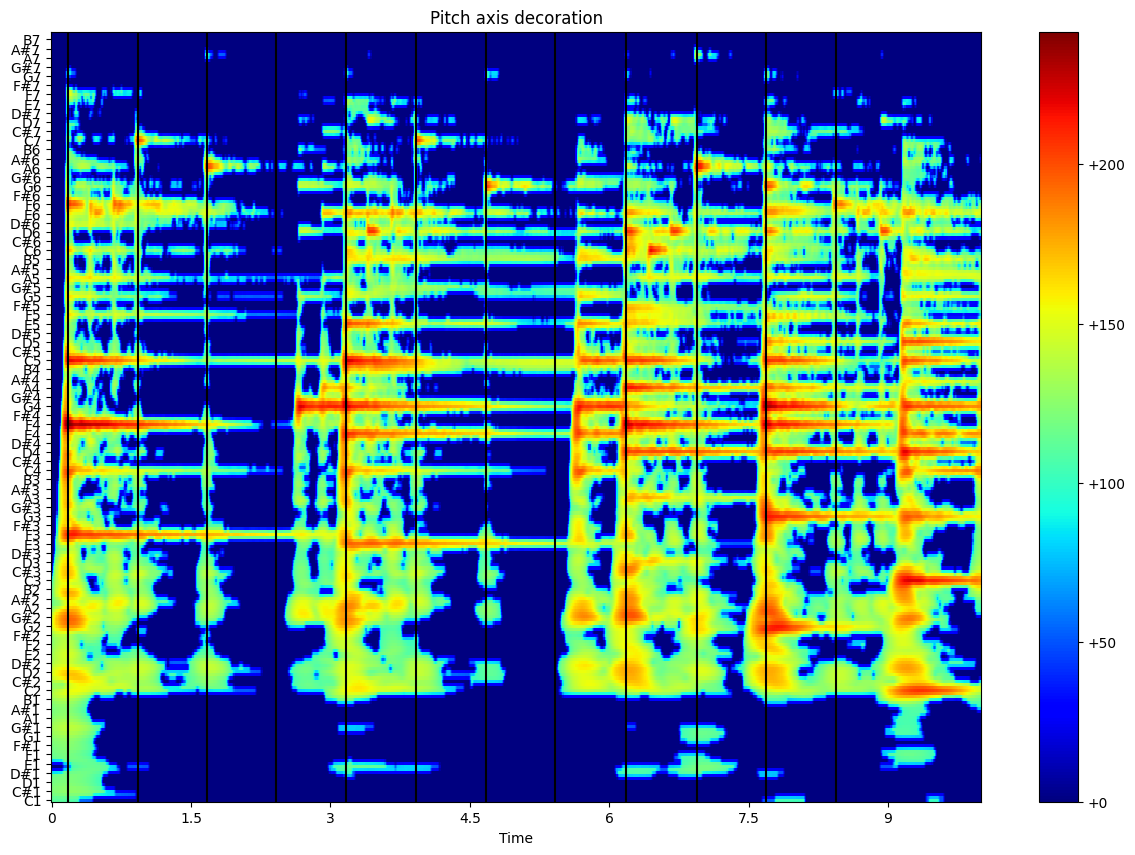

In [13]:
src = c_stretching_pre
src = cv2.filter2D(src, -1, gaussian_mask)
# src = cv2.filter2D(src, -1, sharpening_mask1)
# sharpening_out2 = cv2.filter2D(src, -1, sharpening_mask2)

notes = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
y_ticks = np.arange(0,12*freq_w*octave,freq_w)
y_list=[]

for o in range(octave):
    for i in range(12):
        y_list.append(notes[i]+'%d'%(o+1))

plt.style.use('default')
fig, ax = plt.subplots(1,1,figsize=(15,10))
img = librosa.display.specshow(src, sr=sr, x_axis='time', ax=ax, hop_length= hop_len, bins_per_octave= 12*freq_w,
                               cmap='jet'
                               )
ax.set(title='Pitch axis decoration')
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_list)
fig.colorbar(img, ax=ax, format="%+2d")
for i in beat_times:
    ax.axvline(i,c='k')

plt.show()

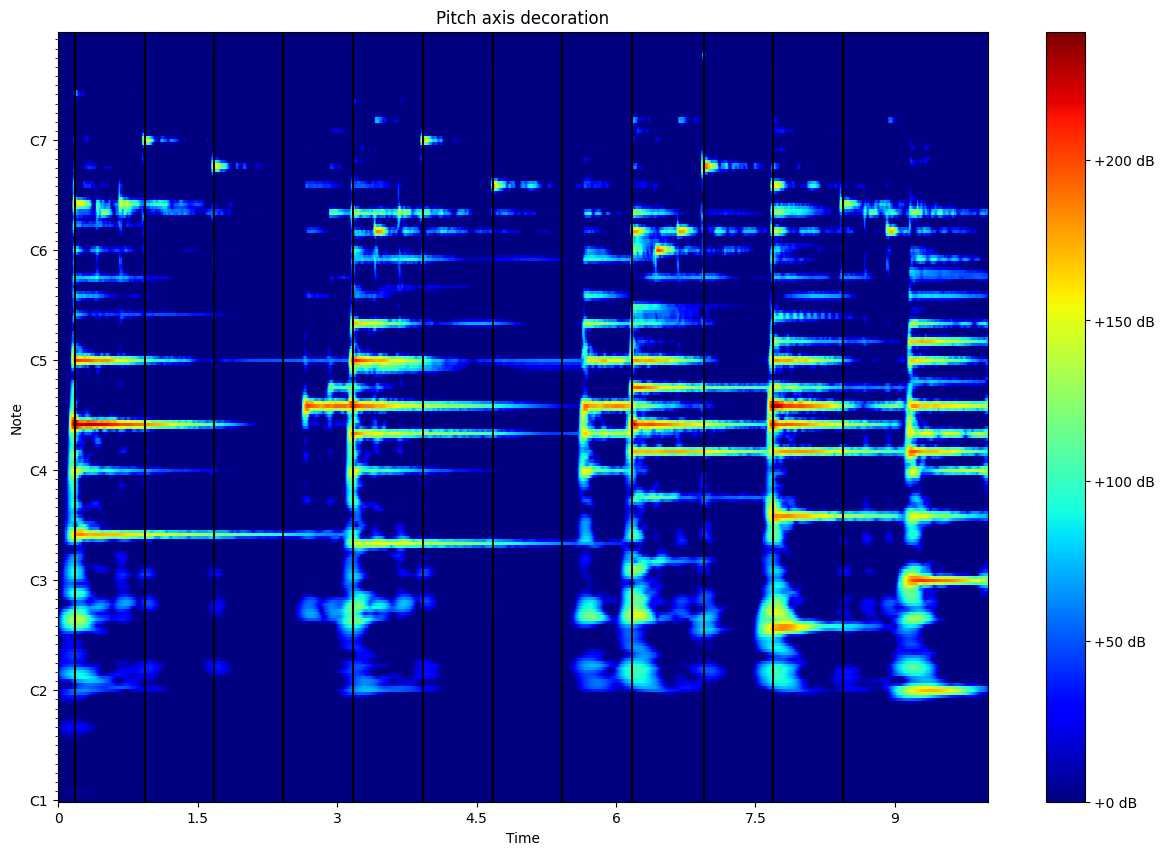

In [29]:
c_y = c_gray

fig, ax = plt.subplots(1,1,figsize=(15,10))
img = librosa.display.specshow(c_y, sr=sr, y_axis='cqt_note', x_axis='time', ax=ax, hop_length= hop_len, bins_per_octave= 12*freq_w, cmap='jet')
ax.set(title='Pitch axis decoration')
fig.colorbar(img, ax=ax, format="%+2d dB")
for i in beat_times:
    ax.axvline(i,c='k')

plt.show()

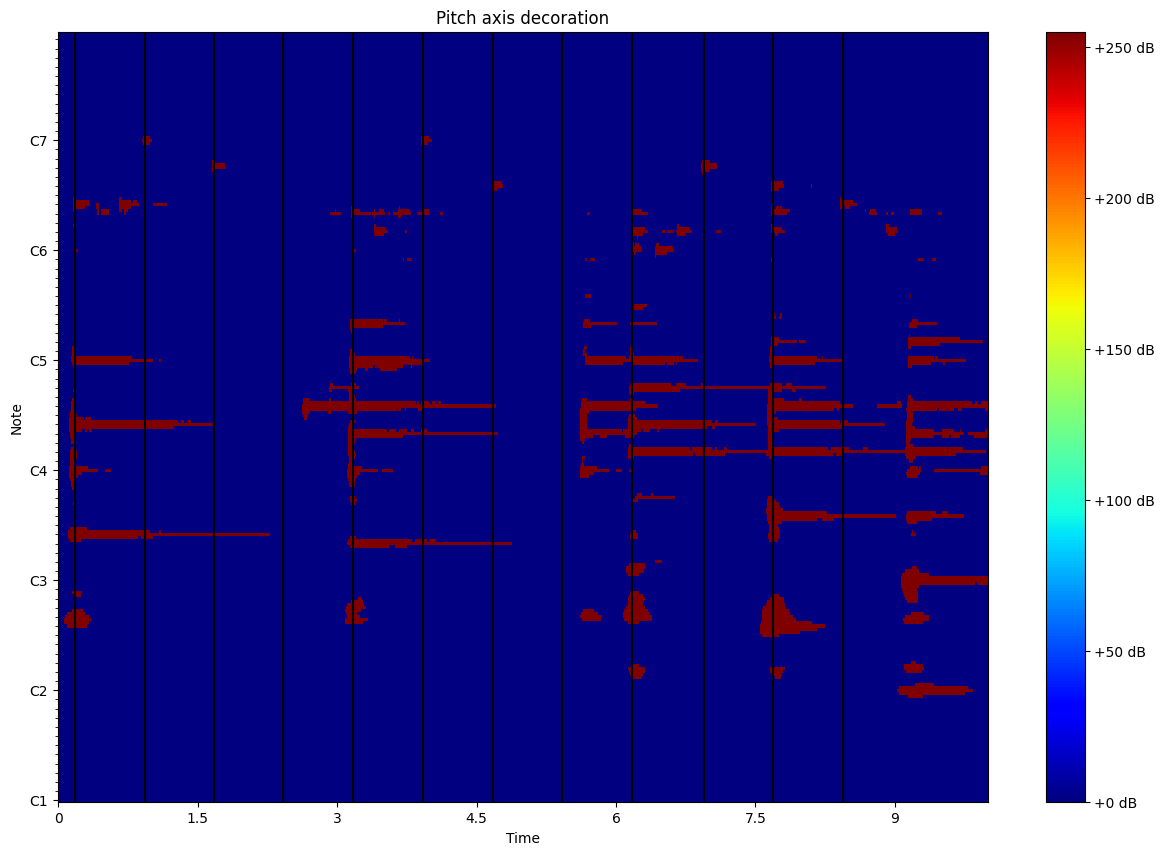

In [27]:
_, c_y = cv2.threshold(c_gray, 120, 255, cv2.THRESH_BINARY)

fig, ax = plt.subplots(1,1,figsize=(15,10))
img = librosa.display.specshow(c_y, sr=sr, y_axis='cqt_note', x_axis='time', ax=ax, hop_length= hop_len, bins_per_octave= 12*freq_w, cmap='jet')
ax.set(title='Pitch axis decoration')
fig.colorbar(img, ax=ax, format="%+2d dB")
for i in beat_times:
    ax.axvline(i,c='k')

plt.show()

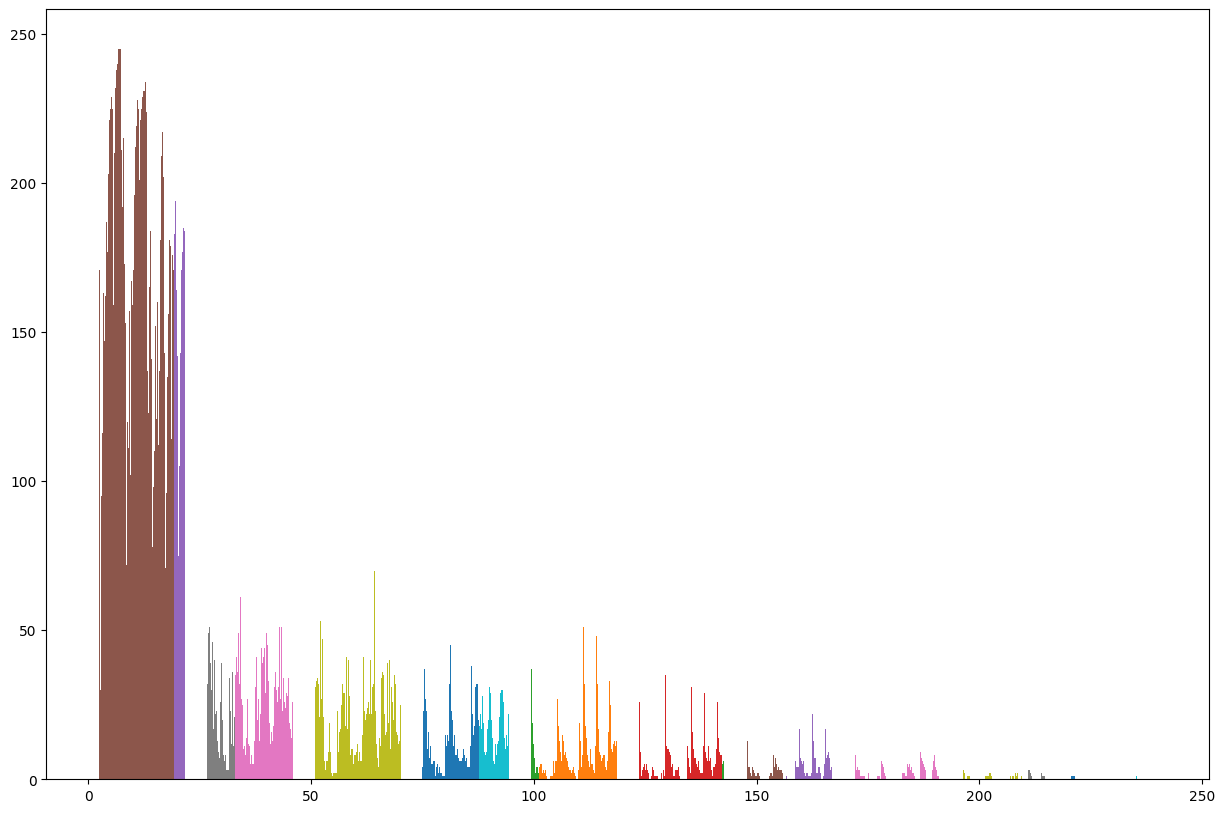

In [21]:
src = c_gray

plt.figure(figsize=(15,10))
plt.hist(src)
plt.show()